<a href="https://colab.research.google.com/github/Stepeech/ImageClassification/blob/main/ImageClassificationPractical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация изображений, полученных в резултьтате аэрокосмической съемки земной поверхности

## Постановка задачи классификации изображений

**Задача классификации изменений** - одна из **фундаментальных** в задачах обработки изображений в целом и обработки данных аэрокосмической съемки в частности.

**Целью классификации изображений** является **определение категории объектов** на изображении. В большинстве случаев рассматривается **классификация** изображений **по наиболее значимому объекту** (одно изображение = одна аннотация), однако существуют также и методы, классифицирующие несколько объектов на изображении.

Важно отметить, что в данной задаче рассматриваются **изображения в целом**, а в качестве аннотаций выступают **текстовые значения классов без пространственной привязки** к изображению. При **повышении детальности классификации** изображения получаются задача **классификации объектов** и задача **семантической сегментации** (попиксельной классификации) С другой стороны, при **добавлении пространственной привязки к аннотациям** получается задача **обнаружения объектов** на изображении.

Пример классификации аэрокосмических изображений ([Набор данных UC Merced](http://weegee.vision.ucmerced.edu/datasets/landuse.html)):

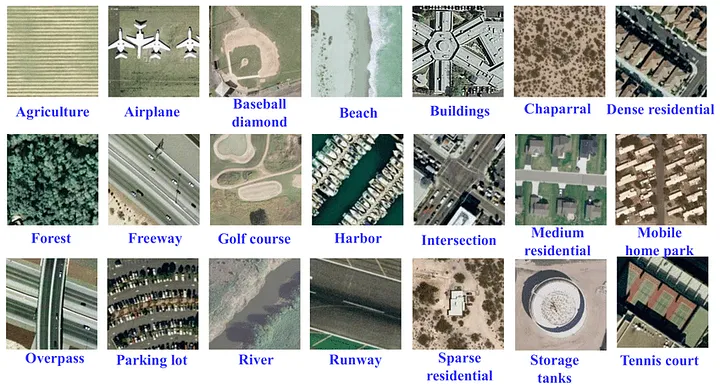

## Применение классификации изображений в задачах обработки данных дистанционного зондирования

Классификацию изображений в задачах обработки данных дистанционного зондирования могут применяться для:

*   классификации земной поверхности;
*   обнаружения объектов на изображении.

Стоит отметить, что практическое применение классификации изображений для этих задач было в значительной степени замещено использованием методов семантической сегментации и обнаружения объектов, соответственно. Тем не менее, классификация всё ещё может использоваться для отбора изображений при подготовке неборов обучающих данных.



## Знакомство с наборами данных для обучения классификации снимков

Традиционная структура набора данных для классификации изображений показана на рисунке ниже:

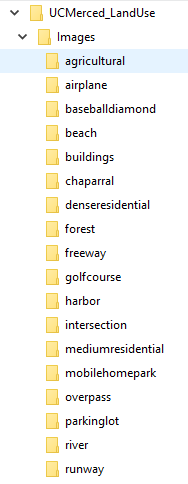

Экземпляры набора (изображения) содержатся в папках, название которых и служит аннотацией экземпляра.


В случаях, когда набор данных разделен на выборки, он выглядит следующим образом:

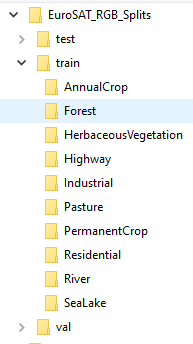

Часто используемые наборы данных дистанционного зондирования, применяющиеся для сравнения моделей классификации изображений:

*   [UC Merced](http://weegee.vision.ucmerced.edu/datasets/landuse.html): 2 100 изображений, 21 класс, по 100 изображений на класс. Размер изображений: 256 на 256 пикселей. Отсутствует разделение на выборки.
*   [EuroSAT](https://github.com/phelber/eurosat): 27 000 изображений, 10 классов, от 2 000 до 3 000 изображений на класс. Существуют RGB и мультиспектральная (6 каналов) варианты набора. Размер изображений: 256 на 256 пикселей. Отсутствует разделение на выборки.
*   [SAT-4](https://www.kaggle.com/datasets/crawford/deepsat-sat4) ([Домашняя страница](https://csc.lsu.edu/~saikat/deepsat/) набора данных больше не позволяет скачать данные): 500 000 изображений, 4 класса, от 90 000 до 180 000 изображений на класс. Размер изображений: 28 на 28 пикселей, 4 канала (RGB + ближний инфракрасный). Существует разделение на обучающую и тестовую выборки.
*   [SAT-6](https://www.kaggle.com/datasets/crawford/deepsat-sat6) ([Домашняя страница](https://csc.lsu.edu/~saikat/deepsat/) набора данных больше не позволяет скачать данные): 405 000 изображений, 6 классов, от 10 000 до 150 000 изображений на класс. Размер изображений: 28 на 28 пикселей, 4 канала (RGB + ближний инфракрасный). Существует разделение на обучающую и тестовую выборки.



## Практический пример классификации изображений

Импорт библиотек

In [ ]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset
if not os.path.exists('./outputs'): os.mkdir('./outputs')

Поделючение к Google Drive

Используемый далее набор данных доступен по [ссылке](https://drive.google.com/drive/folders/1B6PimOtrPfJEgRiT62wQQBFwzNwukooK?usp=share_link)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Определение значений гиперпараметров обучения

В зависимости от применяемой модели машинного обучения, появляется необходимость определить значения ряда гиперпараметров модели, влияющих на качество и скорость обучения системы искусственного интеллекта. В отличие от параметров модели, которые оптимизируются системой в процессе обучения, оптимизация гиперпараметров в процессе обучения невозможна или не имеет смысла.

In [ ]:
USE_CUDA = torch.cuda.is_available() # Использование графического адаптера для обучения

DATASET_PATH = '/content/drive/MyDrive/Datasets/Data_Split'

BATCH_SIZE = 16 # Размер пакета, обрабатываемого моделью за один раз

NUM_EPOCHS = 20 # Количество эпох обучения

DROPOUT_CHANCE = 0.4 # Вероятность того, что одно из значений во входных данных будет "утеряно". Снижает вероятность переобучения

LEARNING_RATE = 0.05 # Темп обучения
GAMMA = 0.9 # Множитель затухания темпа обучения
STEP_SIZE = 5 # Количество эпох между затуханиями

MOMENTUM = 0.5 # Импульс градиентного спуска
WEIGHT_DECAY = 0 # Снижение значений параметров модели

RESIZED_IMAGE_DIMENSION = 64 # Размер изображения при обучении.

random.seed()

Загрузка и подготовка обучающей, тестовой и валидационной выборок

In [ ]:
from torchvision import datasets, models, transforms
data_transforms = transforms.Compose([
        transforms.Resize((RESIZED_IMAGE_DIMENSION, RESIZED_IMAGE_DIMENSION)), #Снижение размерности изображений для ускорения обучения.
        transforms.ToTensor()
    ])

train_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'train'), data_transforms)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

test_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'test'), data_transforms)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

val_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'val'), data_transforms)
val_loader = DataLoader(val_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


class_names = train_dataset.classes

from collections import Counter
total_class_train_examples = list(Counter(train_dataset.targets).values())
total_class_test_examples = list(Counter(test_dataset.targets).values())
total_class_val_examples = list(Counter(val_dataset.targets).values())

print(class_names)
print(total_class_train_examples)
print(total_class_test_examples)
print(total_class_val_examples)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
[2100, 2100, 2100, 1750, 1750, 1400, 1750, 2100, 1750, 2100]
[450, 450, 450, 375, 375, 300, 375, 450, 375, 450]
[450, 450, 450, 375, 375, 300, 375, 450, 375, 450]


Отображение случайного изображения из обучающей выборки

Аннотация изображения: River


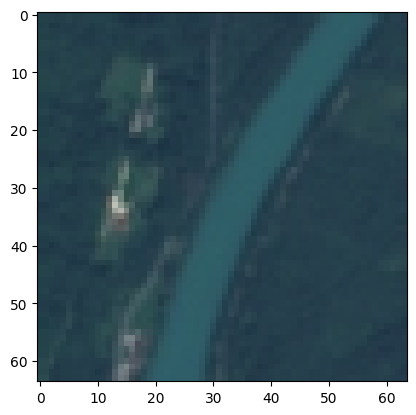

In [ ]:
random_image_index = random.randrange(len(train_dataset)-1)

random_image = train_dataset[random_image_index][0].numpy().transpose((1, 2, 0))
random_image = np.clip(random_image, 0, 1)
print("Аннотация изображения:", class_names[train_dataset[random_image_index][1]])
plt.imshow(random_image)

Создание класса модели

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(4)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(8)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(in_features= (8 * RESIZED_IMAGE_DIMENSION * RESIZED_IMAGE_DIMENSION // 16) , out_features=32)
        self.droput = nn.Dropout(p=DROPOUT_CHANCE)
        self.fc2 = nn.Linear(in_features=32, out_features=len(class_names))

#

    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        out = out.view(x.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        return out

Инициализация модели, критерия вычисления функции потерь, оптимизатора и планировщика

In [ ]:
# Create network
model = CNN()
if USE_CUDA:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

Обучение и тестирование модели

In [ ]:
# Инициализация переменных
train_loss = []
train_accuracy = []
train_class_accuracy = []
test_loss = []
test_accuracy = []
test_class_accuracy = []
epochs = []
best_accuracy = 0

for epoch in range(1, NUM_EPOCHS+1):
    print(f'Эпоха {epoch} из {NUM_EPOCHS}...\n')
    epochs.append(epoch)

    #-------------------------Обучение-------------------------
    correct = 0
    class_correct = np.zeros(len(class_names))
    iterations = 0
    iter_loss = 0.0

    model.train()

    for i in train_loader:

        inputs = i[0]
        labels = i[1]

        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        iter_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        for j in range(len(class_correct)):
            class_correct[j] += torch.logical_and((predicted == labels), (predicted == j)).sum()

        iterations += 1

    scheduler.step()

    train_loss.append(iter_loss/iterations)
    train_accuracy.append((100 * correct / len(train_dataset)))
    train_class_accuracy.append(list((100 * class_correct) / total_class_train_examples))

    print(f'Результаты обучения в {epoch} эпохе: Значение функции потерь = {train_loss[-1]} | Точность = {train_accuracy[-1]} | Поклассовая точность = {train_class_accuracy[-1]}\n')


    #-------------------------Проверка точности обучения--------------------------

    correct = 0
    iterations = 0
    testing_loss = 0.0
    class_correct = np.zeros(len(class_names))

    model.eval()

    for i in test_loader:

        inputs = i[0]
        labels = i[1]

        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        testing_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()

        for j in range(len(class_correct)):
            class_correct[j] += torch.logical_and((predicted == labels), (predicted == j)).sum()

        iterations += 1


    test_loss.append(testing_loss/iterations)
    test_accuracy.append((100 * correct / len(test_dataset)))
    test_class_accuracy.append(list(100 * (class_correct / total_class_test_examples)))

    #Сохранение лучшей модели
    if test_accuracy[-1] > best_accuracy:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss,
            }, 'best_model.pt')

    print(f'Результаты тестирования в {epoch} эпохе: Значение функции потерь = {test_loss[-1]} | Точность = {test_accuracy[-1]} | Поклассовая точность = {test_class_accuracy[-1]}\n')


Эпоха 1 из 20...

Результаты обучения в 1 эпохе: Значение функции потерь = 1.8857865070328494 | Точность = 27.068784713745117 | Поклассовая точность = [36.04761904761905, 44.714285714285715, 18.333333333333332, 3.257142857142857, 43.31428571428572, 0.2857142857142857, 9.82857142857143, 34.76190476190476, 43.31428571428572, 26.476190476190474]

Результаты тестирования в 1 эпохе: Значение функции потерь = 1.509582508502044 | Точность = 38.0 | Поклассовая точность = [77.11111111111111, 62.88888888888889, 8.88888888888889, 0.5333333333333333, 92.80000000000001, 8.666666666666668, 1.3333333333333335, 27.111111111111114, 34.4, 52.666666666666664]

Эпоха 2 из 20...

Результаты обучения в 2 эпохе: Значение функции потерь = 1.5861930100849235 | Точность = 38.42857360839844 | Поклассовая точность = [52.76190476190476, 56.904761904761905, 28.571428571428573, 7.714285714285714, 56.91428571428571, 22.071428571428573, 10.057142857142857, 55.19047619047619, 44.91428571428571, 38.04761904761905]

Резу

Визуализация процесса обучения

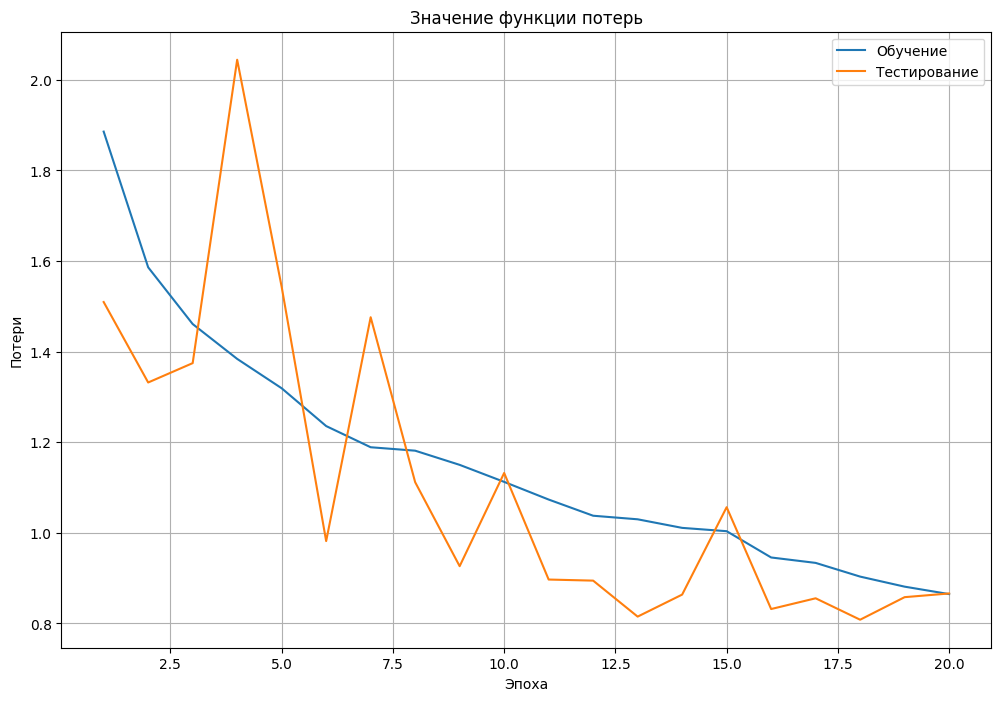

In [ ]:

plt.figure(figsize=(12, 8), num=1)
plt.clf()
plt.plot(epochs, train_loss, label='Обучение')
plt.plot(epochs, test_loss, label='Тестирование')
plt.legend()
plt.grid()
plt.title('Значение функции потерь')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.savefig('outputs/01-loss.pdf')

Валидация обучения с использованием наилучшей модели

In [ ]:
val_loss = 0
val_accuracy = 0
val_class_accuracy = 0

#-------------------------Валидация-------------------------

correct = 0
class_correct = np.zeros(len(class_names))

model = CNN()
if USE_CUDA:
    model = model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

checkpoint = torch.load('best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

for i in val_loader:

    inputs = i[0]
    labels = i[1]

    if USE_CUDA:
        inputs = inputs.cuda()
        labels = labels.cuda()

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    val_loss = loss.item()
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum()

    for j in range(len(class_correct)):
        class_correct[j] += torch.logical_and((predicted == labels), (predicted == j)).sum()


val_accuracy = ((100 * correct / len(val_dataset)))

val_class_accuracy = (list(100 * (class_correct / total_class_test_examples)))

print(f'Результаты валидации: Значение функции потерь = {val_loss} | Точность = {val_accuracy} | Поклассовая точность = {val_class_accuracy}\n')



Результаты валидации: Значение функции потерь = 0.48426324129104614 | Точность = 71.18518829345703 | Поклассовая точность = [78.22222222222223, 82.22222222222221, 38.0, 56.8, 92.26666666666667, 60.333333333333336, 50.13333333333333, 84.44444444444444, 73.6, 90.22222222222223]

